### Persistence Model - Benchmark

Establishing a baseline is essential on any time series forecasting problem. A baseline in performance gives you an idea of how well all other models will actually perform on your problem, a point of comparison. If a model achieves performance at or below the baseline, the technique should be fixed or abandoned. The technique used to generate a forecast to calculate the baseline performance must be easy to implement and naive of problem-specific details.

The most common baseline method for supervised machine learning is the Zero Rule algorithm. This algorithm predicts the majority class in the case of classification, or the average outcome in the case of regression. This could be used for time series, but does not respect the serial correlation structure in time series datasets. The equivalent technique for use with time series dataset is the persistence algorithm.

The persistence algorithm uses the value at the current time step (t) to predict the expected outcome at the next time step (t+1).

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series
from utils import plot_residual_forecast_error, print_performance_metrics
from utils import get_range, difference, inverse_difference
from utils import train_test_split, NN_walk_forward_validation

In [22]:
apple_close_price = get_apple_close_price()

In [23]:
short_series = get_range(apple_close_price, '2003-01-01')

In [24]:
# Model parameters
look_back = 5 # days window look back
n_features = 1 # our only feature will be Close price 
n_outputs = 5 # days forecast

We need to first train/test split, then transform and scale our data

In [25]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [26]:
train, test= train_test_split(apple_close_price,'2018-05-31')

In [27]:
boxcox_series, lmbda = boxcox(train.values)

In [28]:
transformed_train = boxcox_series
transformed_test = boxcox(test, lmbda=lmbda)

# transformed_train = train.values
# transformed_test = test.values

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
scaler = MinMaxScaler()

In [31]:
scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))
scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

In [32]:
X_train, y_train = split_sequence(scaled_train, look_back, n_outputs)
y_train = y_train.reshape(-1, n_outputs)

In [33]:
# The prediction is the last n_outputs of the window (naive prediction)
def persistence_model(x_input, n_outputs):
    return x_input[-n_outputs:]

In [34]:
def persistence_walk_forward_validation(train, test, 
                                        size=1, 
                                        look_back=1, n_outputs=1):
    
    past = train.reshape(-1,).copy()
    future = test.reshape(-1,)[:size]
    
    predictions = list()
    limit_range = len(future)

    for t in range(0, limit_range, n_outputs):
        x_input = past[-look_back:] # grab the last look_back days from the past
        
        # predict the next n_outputs days
        y_hat = persistence_model(x_input.reshape(-look_back,), n_outputs)
        
        # predict the next n_outputs days
        predictions.append(y_hat.reshape(-look_back,)[-n_outputs:])

        # add the new n_outputs days (real ones) to the past
        past = np.concatenate((past, future[t:t+n_outputs]))
            
    return np.array(predictions).reshape(-1,)[:len(future)]

In [35]:
size = 252 # approx. one year
predictions = persistence_walk_forward_validation(scaled_train, 
                                                  scaled_test[:252],
                                                  size=size,
                                                  look_back=look_back, 
                                                  n_outputs=n_outputs)

In [36]:
from utils import plot_walk_forward_validation
from utils import plot_residual_forecast_error, print_performance_metrics

We need to revert the scaling and transformation:

In [37]:
descaled_preds = scaler.inverse_transform(predictions.reshape(-1, 1))
descaled_test = scaler.inverse_transform(scaled_test.reshape(-1, 1))

descaled_preds = inv_boxcox(descaled_preds, lmbda)
descaled_test = inv_boxcox(descaled_test, lmbda)

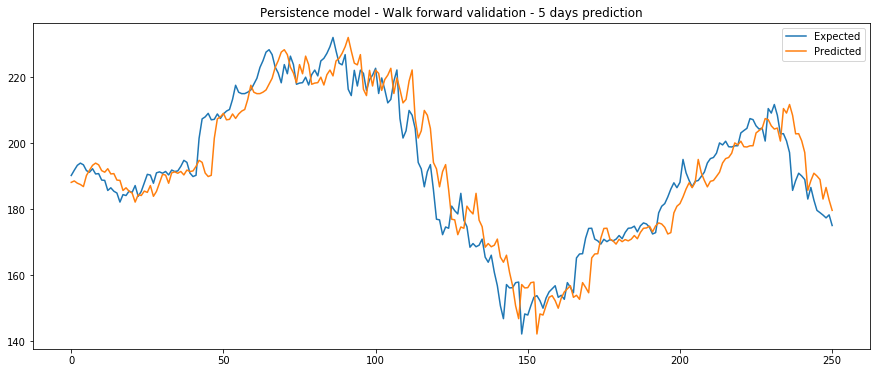

In [38]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(descaled_test[:size])
plt.plot(descaled_preds)
ax.set_title('Persistence model - Walk forward validation - {} days prediction'.format(n_outputs))
ax.legend(['Expected', 'Predicted'])

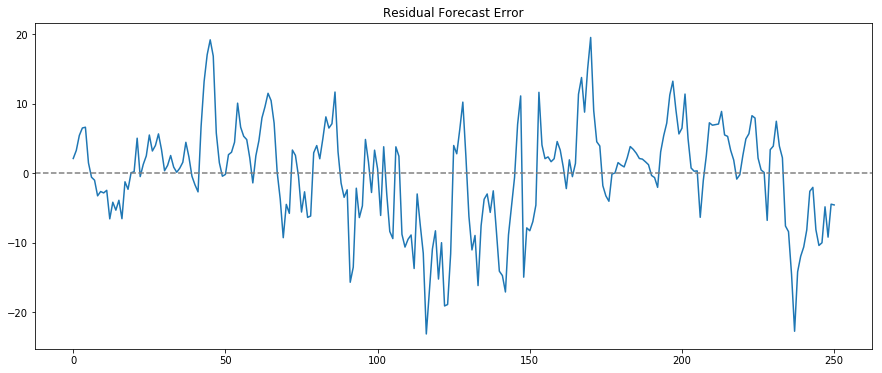

In [39]:
plot_residual_forecast_error(descaled_preds, descaled_test[:size])

In [40]:
print_performance_metrics(descaled_preds, 
                          descaled_test[:size],
                          model_name='Persistence model', 
                          total_days=size, steps=n_outputs)

Persistence model[252 days, 5 days forecast]:

Forecast Bias: -0.203
MAE: 5.729
MSE: 54.819
RMSE: 7.404
MAPE: 3.050
